# Coral Bleaching
# Modeling

1. Imports
2. Initial Evaluation of Models and Sampling Methods
3. Feature Importance
4. Hyperparameter Tuning
5. Compare Tuned Models
6. Select & Save Final Model

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC  # use linearSVC if taking too long (better for larger data sets)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Metrics & evalulation
from sklearn import __version__ as sklearn_version 
from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score,
                              recall_score, f1_score,
                              confusion_matrix, ConfusionMatrixDisplay)

seed = 5

In [2]:
# import undersampled data
datapath1 = '../data/processed/undersample_data/'
data_files = ['X_train_data.csv', 'X_train_scaled_data.csv', 'y_train_data.csv', 
              'X_test_data.csv', 'X_test_scaled_data.csv', 'y_test_data.csv']


X_tr_under, X_tr_under_scl, y_tr_under, X_ts_under, X_ts_under_scl, y_ts_under = \
                            (pd.read_csv(datapath1 + filename, index_col='Unnamed: 0') for filename in data_files)
y_tr_under = y_tr_under.values.ravel()
y_ts_under = y_ts_under.values.ravel()

In [3]:
# import oversampled data
datapath2 = '../data/processed/oversample_data/'
data_files = ['X_train_data.csv', 'X_train_scaled_data.csv', 'y_train_data.csv', 
              'X_test_data.csv', 'X_test_scaled_data.csv', 'y_test_data.csv']


X_tr_over, X_tr_over_scl, y_tr_over, X_ts_over, X_ts_over_scl, y_ts_over = \
                            (pd.read_csv(datapath2 + filename, index_col='Unnamed: 0') for filename in data_files)
y_tr_over = y_tr_over.values.ravel()
y_ts_over = y_ts_over.values.ravel()

## 2. Initial Evaluation of Models and Sampling Methods

Since this is a classification problem with supervised learning, I will start by evaluating the following models:

- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
- [Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
- [K Nearest Neighbors(KNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
- [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
- [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)
- [XGBoost](https://xgboost.readthedocs.io/en/stable/python/)

Initially I will be comparing how these models perform out of the box. While the results include accuracy, precision, recall, and F1 scores, I will ultimately be focused on the F1 scores since it minimizes both false negatives and false positives. After seeing how all of the models perform on both the undersampled and over sampled data, I can determine which sampling method produced the best results. Additionally, I will assess which models have the best performance and select 2-3 models to continue with further feature selection and hyperparameter tuning. 

As a note, I am using the scaled data at this initial step because logistic regression and KNN need scaled data in order to equally weight all features. In later steps, I may change to unscaled data as applicable if fine tuning tree based models in order to simplify the interpretability of the results. 

In [4]:
# function to evaluate metrics for each classifier
def score_predictions(y_test, y_pred):
    '''
    takes test and predicted y,
    returns accuracy, precision, recall, and f1 scores. 
    '''
    
    scores = {}
    scores['accuracy'] = accuracy_score(y_test, y_pred)
    scores['precision'] = precision_score(y_test, y_pred)
    scores['recall'] = recall_score(y_test, y_pred)
    scores['f1'] = f1_score(y_test, y_pred)
    
    return scores
    

# function modeling each classifier 
def compare_classifiers(classifiers, X, y, metrics):
    '''
    takes list of classifiers, X, y, and list of scoring metrics,
    returns dataframe of the classifiers and their respective scores. 
    '''
    scores_agg = pd.DataFrame()
    
    for clf in classifiers:
        cv_clf = cross_val_predict(clf, X, y, cv=5)
        scores = score_predictions(y, cv_clf)
        clf_name = clf.__class__.__name__
        row = [clf_name] + [scores[metric] for metric in metrics]
        scores_agg = pd.concat([scores_agg, pd.Series(row)], axis=1)

    cols = ['Classifier'] + metrics
    scores_agg = pd.DataFrame(scores_agg.T)
    scores_agg.columns = cols
    scores_agg.set_index('Classifier', inplace=True)
    
    return scores_agg


In [5]:
# Establish classifiers and metrics of interest
# LogisticRegression needed increased max_iter
classifier_list = [LogisticRegression(max_iter=300), SVC(), KNeighborsClassifier(), 
                   DecisionTreeClassifier(), RandomForestClassifier(), 
                   GradientBoostingClassifier(), XGBClassifier()]

metrics = ['accuracy', 'precision', 'recall', 'f1']

### 2a. Undersampled Data

In [6]:
# initial comparison of undersampled data
initial_under = compare_classifiers(classifier_list, X_tr_under_scl, y_tr_under, metrics)
initial_under

,accuracy,precision,recall,f1
Classifier,,,,
LogisticRegression,0.721139,0.709282,0.746271,0.727306
SVC,0.797289,0.820423,0.759433,0.788751
KNeighborsClassifier,0.816154,0.820148,0.808324,0.814193
DecisionTreeClassifier,0.846827,0.842699,0.851573,0.847113
RandomForestClassifier,0.896302,0.899052,0.892065,0.895545
GradientBoostingClassifier,0.797164,0.806109,0.780745,0.793224
XGBClassifier,0.872314,0.879882,0.861351,0.870518


Text(0.5, 1.0, 'Initial Model Comparison - Undersampled Data')

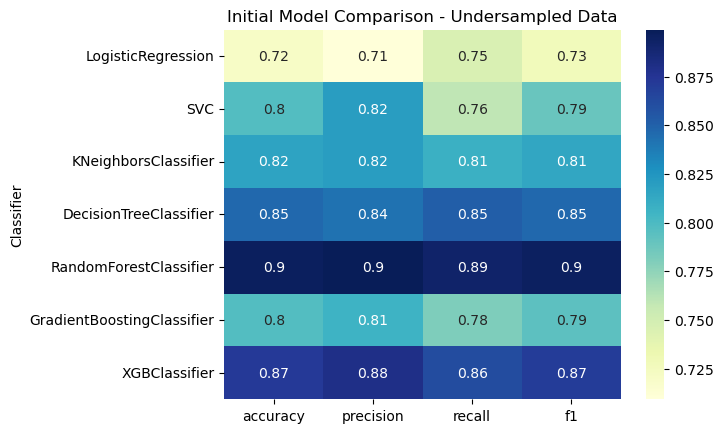

In [7]:
# Visualize scores via heatmap
sns.heatmap(initial_under.astype('float'), cmap='YlGnBu', annot=True)
plt.title('Initial Model Comparison - Undersampled Data')

### 2b. Oversampled Data

In [8]:
# initial comparison of oversampled data
initial_over = compare_classifiers(classifier_list, X_tr_over_scl, y_tr_over, metrics)
initial_over

,accuracy,precision,recall,f1
Classifier,,,,
LogisticRegression,0.74387,0.725837,0.781702,0.752734
SVC,0.829669,0.845188,0.80613,0.825197
KNeighborsClassifier,0.878815,0.867361,0.893678,0.880323
DecisionTreeClassifier,0.918469,0.929168,0.905555,0.917209
RandomForestClassifier,0.94956,0.953667,0.944764,0.949195
GradientBoostingClassifier,0.841335,0.857003,0.818422,0.837269
XGBClassifier,0.924444,0.939407,0.907007,0.922923


Text(0.5, 1.0, 'Initial Model Comparison - Oversampled Data')

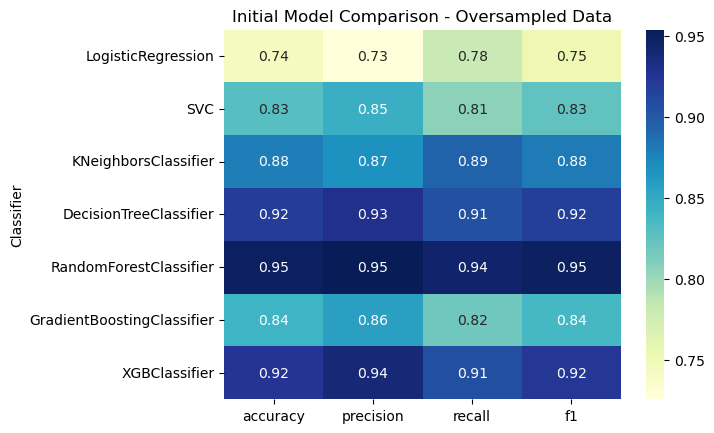

In [9]:
# Visualize scores via heatmap
sns.heatmap(initial_over.astype('float'), cmap='YlGnBu', annot=True)
plt.title('Initial Model Comparison - Oversampled Data')

These results show that the oversampled data produces higher scores across all models, and I will move forward with the oversampled data. However regardless of sampling method, I have shortlisted three classifiers to continue with hyperparameter tuning: 
- Decision Tree
- Random Forest
- XGBoost

Out of the Box, Random Forest performs the best across all metrics, with XGBoost and Decision Tree only a couple basis points behind. Decision Tree is much faster and more efficient than the other two ensemble models, and therefore could be attractive if it's performance can be fine tuned. 

*I will also be using the unscaled data moving forward because these three models are tree based, and therefore do not required scaled data.*

## 3. Feature Importance


At this stage, I am interested in what features are most important. As part of the hyperparameter tuning in the next step, I will want to compare how the models perform with a reduced number of features. Reducing the number of features can help interpretability as well as mitigate overfitting of the models.

In [10]:
# initialize shortlist models

# Decision Tree
dt_clf = DecisionTreeClassifier(random_state=seed)
dt_clf.fit(X_tr_over, y_tr_over)

# Random Forest
rf_clf = RandomForestClassifier(random_state=seed)
rf_clf.fit(X_tr_over, y_tr_over)

# XGBoost
xgb_clf = XGBClassifier(random_state=seed)
xgb_clf.fit(X_tr_over, y_tr_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=5, ...)

In [11]:
def graph_importance(clf):
    importance = pd.DataFrame(clf.feature_importances_, columns=['importance'])
    importance['feature'] = X_tr_over.columns
    importance.sort_values(by='importance', ascending=False)

    sns.barplot(data=importance.sort_values(by='importance', ascending=False),
                y='feature', x='importance')
    plt.title(clf.__class__.__name__ + ' Feature Importance')
    plt.show()

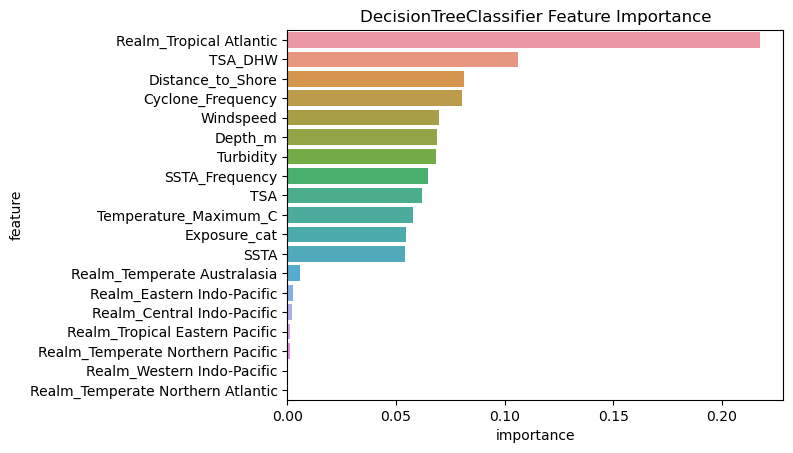

In [12]:
graph_importance(dt_clf)

In [13]:
# Select features with importance greater than ~0.08
dt_features = ['Realm_Tropical Atlantic', 'TSA_DHW', 'Distance_to_Shore', 'Cyclone_Frequency', 
              'Windspeed', 'Depth_m', 'Turbidity']

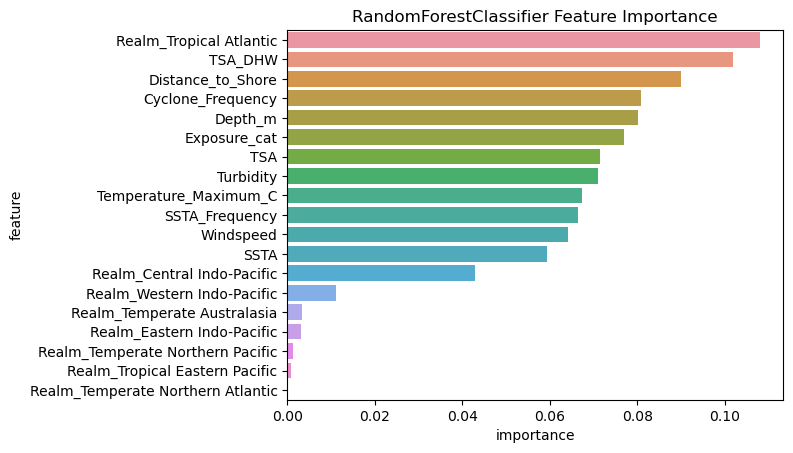

In [14]:
graph_importance(rf_clf)

In [15]:
# Select features with importance greater than ~0.08
rf_features = ['Realm_Tropical Atlantic', 'TSA_DHW', 'Distance_to_Shore', 
               'Depth_m', 'Cyclone_Frequency', 'Exposure_cat']

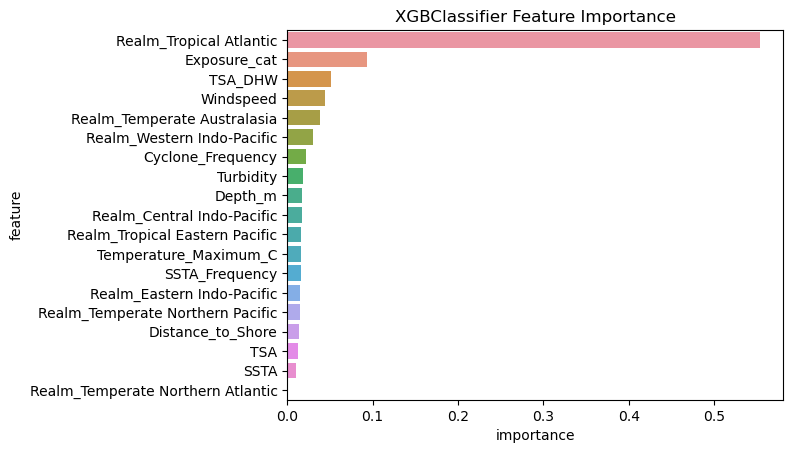

In [16]:
graph_importance(xgb_clf)

In [17]:
# Select features where importance appears to drop off (after Cyclone_Frequency)
xgb_features = ['Realm_Tropical Atlantic', 'Exposure_cat', 'TSA_DHW', 'Windspeed',
                'Realm_Temperate Australasia', 'Realm_Western Indo-Pacific', 'Cyclone_Frequency']

## 4. Hyperparameter Tuning

In [18]:
def model_evaluation(classifier, params, X_train, y_train, X_test, y_test):
    '''
    Takes classifier name, dict of parameters, X_train, y_train, X_test, y_test, 
    prints best parameters and scores, 
    returns fit model with best parameters and scores.
    '''
    start_time = datetime.now()
    
    # grid search cross validation for best params
    clf = classifier(random_state=seed)
    cv = GridSearchCV(clf, params, cv=5)
    cv.fit(X_train, y_train)
    
    # fit and predict model with best params
    best_clf = classifier(**cv.best_params_)
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
    
    # calculate scores
    scores = score_predictions(y_test, y_pred)
    
    print(f'Total Run Time: {datetime.now() - start_time}')
    print('')
    print(f'Best Parameters: {cv.best_params_}')
    print('')
    print('Test data scores ')
    for x in scores:
        print(x, ':', scores[x])
        
    return best_clf, scores

### 4a. Decision Tree
#### 4a i. All Features

In [19]:
dt_params = {'criterion':['gini', 'entropy'], 
             'max_depth':[5, 10, 15, 25, 30]}

best_dt, best_dt_scores = model_evaluation(DecisionTreeClassifier, dt_params, 
                           X_tr_over, y_tr_over, X_ts_over, y_ts_over)

Total Run Time: 0:00:09.646760

Best Parameters: {'criterion': 'entropy', 'max_depth': 30}

Test data scores 
accuracy : 0.9333747154976205
precision : 0.9476130122517955
recall : 0.9188857025809095
f1 : 0.9330282861896838


#### 4a ii. Reduced Features

In [20]:
# reduced features selected in previous section
X_tr_dt = X_tr_over[dt_features]
X_ts_dt = X_ts_over[dt_features]

dt_params = {'criterion':['gini', 'entropy'], 
             'max_depth':[5, 10, 15, 25, 30]}

best_dt_reduced, best_dt_reduced_scores = model_evaluation(DecisionTreeClassifier, dt_params, 
                                   X_tr_dt, y_tr_over, X_ts_dt, y_ts_over)

Total Run Time: 0:00:05.254076

Best Parameters: {'criterion': 'entropy', 'max_depth': 30}

Test data scores 
accuracy : 0.9198220566935651
precision : 0.9353402586389654
recall : 0.9037279803359279
f1 : 0.9192624231690801


### 4b. Random Forest
#### 4b i. All Features

In [21]:
rf_params = {'n_estimators':[50, 100, 150],
             'criterion':['gini', 'entropy'], 
             'max_depth':[5, 10, 15, 25, 30]}

best_rf, best_rf_scores = model_evaluation(RandomForestClassifier, rf_params, 
                           X_tr_over, y_tr_over, X_ts_over, y_ts_over)

Total Run Time: 0:07:35.163337

Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 150}

Test data scores 
accuracy : 0.9557210842127043
precision : 0.963765097875885
recall : 0.9479721425645228
f1 : 0.9558033870301529


#### 4b ii. Reduced Features

In [22]:
# reduced features selected in previous section
X_tr_rf = X_tr_over[rf_features]
X_ts_rf = X_ts_over[rf_features]

rf_params = {'n_estimators':[50, 100, 150],
             'criterion':['gini', 'entropy'], 
             'max_depth':[5, 10, 15, 25, 30]}

best_rf_reduced, best_rf_reduced_scores = model_evaluation(RandomForestClassifier, rf_params, 
                                   X_tr_rf, y_tr_over, X_ts_rf, y_ts_over)

Total Run Time: 0:05:10.672745

Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 100}

Test data scores 
accuracy : 0.9276846679081316
precision : 0.9418973167124446
recall : 0.9131503482179435
f1 : 0.9273010920436818


### 4c. XGBoost
#### 4c i. All Features

In [23]:
xgb_params = {'max_depth': [5, 10, 15, 25, 30], 
              'n_estimators': [50, 100, 150],
              'reg_alpha': [0.05, 0.1, 1.0], 
              'reg_lambda': [0.05, 1.0, 2.0]}

best_xgb, best_xgb_scores = model_evaluation(XGBClassifier, xgb_params, 
                            X_tr_over, y_tr_over, X_ts_over, y_ts_over)

Total Run Time: 0:06:33.140362

Best Parameters: {'max_depth': 25, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 1.0}

Test data scores 
accuracy : 0.9591351127663977
precision : 0.964781437746012
recall : 0.9539123310118803
f1 : 0.9593160984653414


#### 4c ii. Reduced Features

In [24]:
# reduced features selected in previous section
X_tr_xgb = X_tr_over[xgb_features]
X_ts_xgb = X_ts_over[xgb_features]

xgb_params = {'max_depth': [5, 10, 15, 25, 30], 
              'n_estimators': [50, 100, 150],
              'reg_alpha': [0.05, 0.1, 1.0], 
              'reg_lambda': [0.05, 1.0, 2.0]}

best_xgb_reduced, best_xgb_reduced_scores = model_evaluation(XGBClassifier, xgb_params, 
                                    X_tr_xgb, y_tr_over, X_ts_xgb, y_ts_over)

Total Run Time: 0:04:31.448536

Best Parameters: {'max_depth': 15, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 1.0}

Test data scores 
accuracy : 0.9081315952824333
precision : 0.9283569283569284
recall : 0.8865219172470299
f1 : 0.9069572506286673


## 5. Compare Tuned Model

Text(0.5, 1.0, 'Tuned Tree-Based Models Scores')

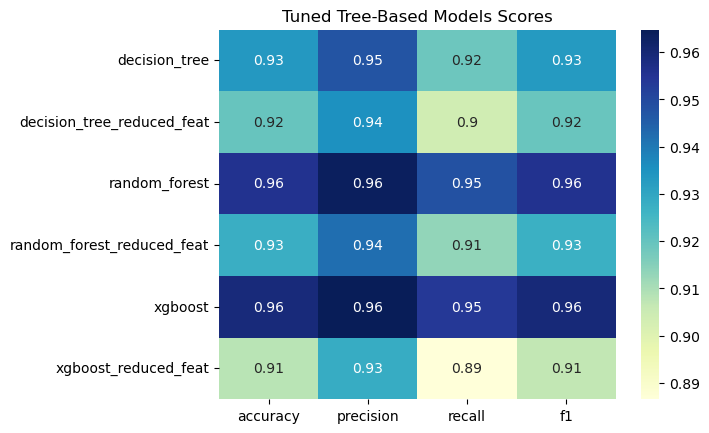

In [25]:
# combine scores into one dataframe with model names 
tuned_scores = [best_dt_scores, best_dt_reduced_scores, best_rf_scores, 
                best_rf_reduced_scores, best_xgb_scores, best_xgb_reduced_scores]
models = ['decision_tree', 'decision_tree_reduced_feat', 'random_forest', 
          'random_forest_reduced_feat', 'xgboost', 'xgboost_reduced_feat']
scores = pd.DataFrame(data=tuned_scores, index = models)

# plot heatmap of scores 
sns.heatmap(scores, cmap='YlGnBu', annot=True)
plt.title('Tuned Tree-Based Models Scores')

In [43]:
# Consider overfitting
tr1_pred = best_xgb.predict(X_tr_over)
tr_xgb_scores = score_predictions(y_tr_over, tr1_pred)

tr2_pred = best_xgb_reduced.predict(X_tr_xgb)
tr_xgb_reduced_scores = score_predictions(y_tr_over, tr2_pred)

print('XGB All Features: ')
print(f"Predicted train F1 score: {tr_xgb_scores['f1']}")
print(f"Predicted test F1 score: {best_xgb_scores['f1']}")
print('')
print('XGB Reduced Features: ')
print(f"Predicted train F1 score: {tr_xgb_reduced_scores['f1']}")
print(f"Predicted test F1 score: {best_xgb_reduced_scores['f1']}")

XGB All Features: 
Predicted train F1 score: 0.9977453546531215
Predicted test F1 score: 0.9593160984653414

XGB Reduced Features: 
Predicted train F1 score: 0.9407639785938364
Predicted test F1 score: 0.9069572506286673


Both Random Forest and XGBoost models perform quite well when using all features, with F1 scores of 0.96. Interestingly, XGBoost is most negatively impacted by the reduction of features compared to both Random Forest and Decision Tree. 

Finally, I looked at the F1 scores from predictions using training data in order to evaluate the possibility of overfitting. This showed that all three models had nearly perfect scores when using all features and therefore indicate the models are overfitted. Additionally, both Decision Tree and Random Forest with reduced features *also* had near perfect training F1 scores. XGBoost with reduced features resulted in an training F1 score of 0.94, which is better in terms of avoiding overfitting. 

For my purposes, I will be using the XGBoost model with reduced features. For my purposes, I will be using the XGBoost model with reduced features. Despite having the lowest F1 score of the tuned models at 0.91, this model is adequate for predicting where coral bleaching is present, while also reducing the complexity of features of the model, as well as reducing overfitting.

## 6. Select & Save Final Model

In [44]:
final_model = best_xgb_reduced

# assign model details
final_model.version = '1.0'
final_model.pandas_version = pd.__version__
final_model.numpy_version = np.__version__
final_model.sklearn_version = sklearn_version
final_model.X_columns = [col for col in X_tr_xgb.columns]
final_model.build_datetime = datetime.now()


# save final model as pickle file
model_path_file = '../models/coral_bleaching_prediction_model.pkl'

with open(model_path_file, 'wb') as file: 
    pickle.dump(final_model, file)
